In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as pimg
import seaborn as sb         # 一个构建在matplotlib上的绘画模块，支持numpy,pandas等数据结构
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix     # 混淆矩阵

import itertools
#  keras
from keras.utils import to_categorical         #数字标签转化成one-hot编码
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

Using TensorFlow backend.


In [2]:
# 设置绘画风格
sb.set(style='white', context='notebook', palette='deep')

In [5]:
# 数据集下载地址 http://yann.lecun.com/exdb/mnist/
import struct
# 训练集文件
train_images_idx3_ubyte_file = 'mnist/train-images.idx3-ubyte'
# 训练集标签文件
train_labels_idx1_ubyte_file = 'mnist/train-labels.idx1-ubyte'

# 测试集文件
test_images_idx3_ubyte_file = 'mnist/t10k-images.idx3-ubyte'
# 测试集标签文件
test_labels_idx1_ubyte_file = 'mnist/t10k-labels.idx1-ubyte'


def decode_idx3_ubyte(idx3_ubyte_file):
    """
    解析idx3文件的通用函数
    :param idx3_ubyte_file: idx3文件路径
    :return: 数据集
    """
    # 读取二进制数据
    bin_data = open(idx3_ubyte_file, 'rb').read()

    # 解析文件头信息，依次为魔数、图片数量、每张图片高、每张图片宽
    offset = 0
    fmt_header = '>iiii'
    magic_number, num_images, num_rows, num_cols = struct.unpack_from(fmt_header, bin_data, offset)
    print ('魔数:%d, 图片数量: %d张, 图片大小: %d*%d' % (magic_number, num_images, num_rows, num_cols))

    # 解析数据集
    image_size = num_rows * num_cols
    offset += struct.calcsize(fmt_header)
    fmt_image = '>' + str(image_size) + 'B'
    images = np.empty((num_images, num_rows, num_cols))
    for i in range(num_images):
        if (i + 1) % 10000 == 0:
            print ('已解析 %d' % (i + 1) + '张')
        images[i] = np.array(struct.unpack_from(fmt_image, bin_data, offset)).reshape((num_rows, num_cols))
        offset += struct.calcsize(fmt_image)
    return images


def decode_idx1_ubyte(idx1_ubyte_file):
    """
    解析idx1文件的通用函数
    :param idx1_ubyte_file: idx1文件路径
    :return: 数据集
    """
    # 读取二进制数据
    bin_data = open(idx1_ubyte_file, 'rb').read()

    # 解析文件头信息，依次为魔数和标签数
    offset = 0
    fmt_header = '>ii'
    magic_number, num_images = struct.unpack_from(fmt_header, bin_data, offset)
    print ('魔数:%d, 图片数量: %d张' % (magic_number, num_images))

    # 解析数据集
    offset += struct.calcsize(fmt_header)
    fmt_image = '>B'
    labels = np.empty(num_images)
    for i in range(num_images):
        if (i + 1) % 10000 == 0:
            print ('已解析 %d' % (i + 1) + '张')
        labels[i] = struct.unpack_from(fmt_image, bin_data, offset)[0]
        offset += struct.calcsize(fmt_image)
    return labels


def load_train_images(idx_ubyte_file=train_images_idx3_ubyte_file):
    """
    TRAINING SET IMAGE FILE (train-images-idx3-ubyte):
    [offset] [type]          [value]          [description]
    0000     32 bit integer  0x00000803(2051) magic number
    0004     32 bit integer  60000            number of images
    0008     32 bit integer  28               number of rows
    0012     32 bit integer  28               number of columns
    0016     unsigned byte   ??               pixel
    0017     unsigned byte   ??               pixel
    ........
    xxxx     unsigned byte   ??               pixel
    Pixels are organized row-wise. Pixel values are 0 to 255. 0 means background (white), 255 means foreground (black).

    :param idx_ubyte_file: idx文件路径
    :return: n*row*col维np.array对象，n为图片数量
    """
    return decode_idx3_ubyte(idx_ubyte_file)


def load_train_labels(idx_ubyte_file=train_labels_idx1_ubyte_file):
    """
    TRAINING SET LABEL FILE (train-labels-idx1-ubyte):
    [offset] [type]          [value]          [description]
    0000     32 bit integer  0x00000801(2049) magic number (MSB first)
    0004     32 bit integer  60000            number of items
    0008     unsigned byte   ??               label
    0009     unsigned byte   ??               label
    ........
    xxxx     unsigned byte   ??               label
    The labels values are 0 to 9.

    :param idx_ubyte_file: idx文件路径
    :return: n*1维np.array对象，n为图片数量
    """
    return decode_idx1_ubyte(idx_ubyte_file)


def load_test_images(idx_ubyte_file=test_images_idx3_ubyte_file):
    """
    TEST SET IMAGE FILE (t10k-images-idx3-ubyte):
    [offset] [type]          [value]          [description]
    0000     32 bit integer  0x00000803(2051) magic number
    0004     32 bit integer  10000            number of images
    0008     32 bit integer  28               number of rows
    0012     32 bit integer  28               number of columns
    0016     unsigned byte   ??               pixel
    0017     unsigned byte   ??               pixel
    ........
    xxxx     unsigned byte   ??               pixel
    Pixels are organized row-wise. Pixel values are 0 to 255. 0 means background (white), 255 means foreground (black).

    :param idx_ubyte_file: idx文件路径
    :return: n*row*col维np.array对象，n为图片数量
    """
    return decode_idx3_ubyte(idx_ubyte_file)


def load_test_labels(idx_ubyte_file=test_labels_idx1_ubyte_file):
    """
    TEST SET LABEL FILE (t10k-labels-idx1-ubyte):
    [offset] [type]          [value]          [description]
    0000     32 bit integer  0x00000801(2049) magic number (MSB first)
    0004     32 bit integer  10000            number of items
    0008     unsigned byte   ??               label
    0009     unsigned byte   ??               label
    ........
    xxxx     unsigned byte   ??               label
    The labels values are 0 to 9.

    :param idx_ubyte_file: idx文件路径
    :return: n*1维np.array对象，n为图片数量
    """
    return decode_idx1_ubyte(idx_ubyte_file)

魔数:2051, 图片数量: 60000张, 图片大小: 28*28
已解析 10000张
已解析 20000张
已解析 30000张
已解析 40000张
已解析 50000张
已解析 60000张
魔数:2049, 图片数量: 60000张
已解析 10000张
已解析 20000张
已解析 30000张
已解析 40000张
已解析 50000张
已解析 60000张
魔数:2051, 图片数量: 10000张, 图片大小: 28*28
已解析 10000张
魔数:2049, 图片数量: 10000张
已解析 10000张
5.0


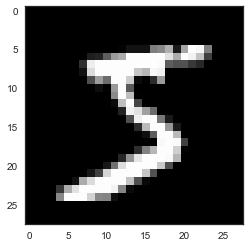

7.0


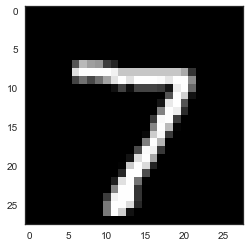

0.0


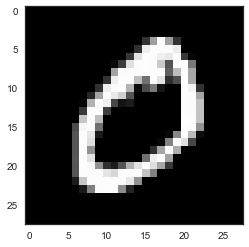

2.0


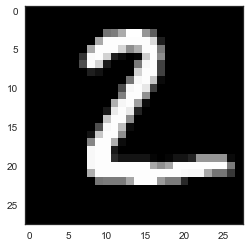

4.0


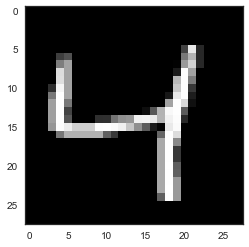

1.0


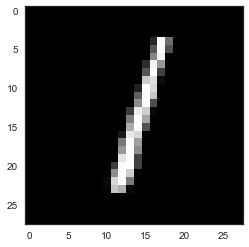

1.0


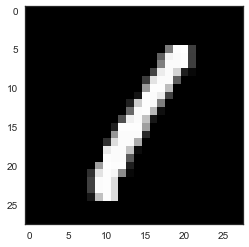

0.0


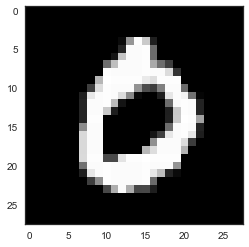

9.0


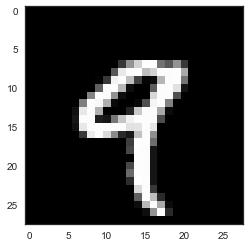

4.0


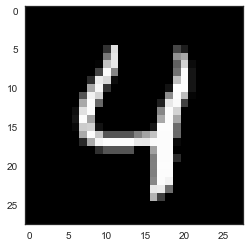

done


In [16]:
# 加载数据
train_x = load_train_images()
train_y = load_train_labels()
test_x = load_test_images()
test_y = load_test_labels()

# 查看前五个训练和测试数据及其标签以读取是否正确
for i in range(5):
    print(train_y[i])
    plt.imshow(train_x[i], cmap='gray')
    plt.show()
    print(test_y[i])
    plt.imshow(test_x[i], cmap='gray')
    plt.show()
print ('done')

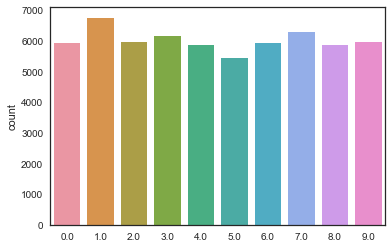

In [17]:
# 观察一下训练数据的分布情况
g = sb.countplot(train_y)

In [18]:
# 归一化
train_x =  train_x/255.0
test_x = test_x/255.0

In [22]:
train_x = train_x.reshape(-1, 28, 28, 1)
test_x = test_x.reshape(-1, 28, 28, 1)

In [40]:
train_y = to_categorical(train_y, num_classes = 10)
test_y = to_categorical(test_y, num_classes = 10)

In [25]:
#从训练数据中分出十分之一的数据作为验证数据
random_seed = 3
train_x , val_x , train_y, val_y = train_test_split(train_x, train_y, test_size=0.1, random_state=random_seed)

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


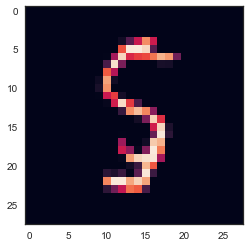

In [28]:
plt.imshow(train_x[0][:,:,0])
print(train_y[0])

In [29]:
model = Sequential()
# 第一个卷积层，32个卷积核，大小５x5，卷积模式SAME,激活函数relu,输入张量的大小
model.add(Conv2D(filters= 32, kernel_size=(5,5), padding='Same', activation='relu',input_shape=(28,28,1)))
model.add(Conv2D(filters= 32, kernel_size=(5,5), padding='Same', activation='relu'))
# 池化层,池化核大小２x2
model.add(MaxPool2D(pool_size=(2,2)))
# 随机丢弃四分之一的网络连接，防止过拟合
model.add(Dropout(0.25))  
model.add(Conv2D(filters= 64, kernel_size=(3,3), padding='Same', activation='relu'))
model.add(Conv2D(filters= 64, kernel_size=(3,3), padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))
# 全连接层,展开操作，
model.add(Flatten())
# 添加隐藏层神经元的数量和激活函数
model.add(Dense(256, activation='relu'))    
model.add(Dropout(0.25))
# 输出层
model.add(Dense(10, activation='softmax'))  

In [30]:
# 设置优化器
# lr :学习效率，　decay :lr的衰减值
optimizer = RMSprop(lr = 0.001, decay=0.0)

In [31]:
# 编译模型
# loss:损失函数，metrics：对应性能评估函数
model.compile(optimizer=optimizer, loss = 'categorical_crossentropy',metrics=['accuracy'])

In [32]:
# keras的callback类提供了可以跟踪目标值，和动态调整学习效率
# moitor : 要监测的量，这里是验证准确率
# matience: 当经过３轮的迭代，监测的目标量，仍没有变化，就会调整学习效率
# verbose : 信息展示模式，去０或１
# factor :　每次减少学习率的因子，学习率将以lr = lr*factor的形式被减少
# mode：‘auto’，‘min’，‘max’之一，在min模式下，如果检测值触发学习率减少。在max模式下，当检测值不再上升则触发学习率减少。
# epsilon：阈值，用来确定是否进入检测值的“平原区”
# cooldown：学习率减少后，会经过cooldown个epoch才重新进行正常操作
# min_lr：学习率的下限
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_acc', patience = 3,
                                            verbose = 1, factor=0.5, min_lr = 0.00001)

In [33]:
epochs = 40
batch_size = 100

In [34]:
# 数据增强处理，提升模型的泛化能力，也可以有效的避免模型的过拟合
# rotation_range : 旋转的角度
# zoom_range : 随机缩放图像
# width_shift_range : 水平移动占图像宽度的比例
# height_shift_range 
# horizontal_filp : 水平反转
# vertical_filp : 纵轴方向上反转
data_augment = ImageDataGenerator(rotation_range= 10,zoom_range= 0.1,
                                  width_shift_range = 0.1,height_shift_range = 0.1,
                                  horizontal_flip = False, vertical_flip = False)

In [35]:
history = model.fit_generator(data_augment.flow(train_x, train_y, batch_size=batch_size),
                             epochs= epochs, validation_data = (val_x,val_y),
                             verbose =2, steps_per_epoch=train_x.shape[0]//batch_size,
                             callbacks=[learning_rate_reduction])

Epoch 1/40
 - 15s - loss: 0.3038 - acc: 0.9031 - val_loss: 0.0452 - val_acc: 0.9868
Epoch 2/40
 - 11s - loss: 0.0963 - acc: 0.9709 - val_loss: 0.0521 - val_acc: 0.9820
Epoch 3/40
 - 10s - loss: 0.0688 - acc: 0.9790 - val_loss: 0.0301 - val_acc: 0.9910
Epoch 4/40
 - 10s - loss: 0.0591 - acc: 0.9822 - val_loss: 0.0238 - val_acc: 0.9933
Epoch 5/40
 - 9s - loss: 0.0529 - acc: 0.9840 - val_loss: 0.0273 - val_acc: 0.9917
Epoch 6/40
 - 9s - loss: 0.0502 - acc: 0.9854 - val_loss: 0.0195 - val_acc: 0.9938
Epoch 7/40
 - 9s - loss: 0.0494 - acc: 0.9854 - val_loss: 0.0242 - val_acc: 0.9925
Epoch 8/40
 - 9s - loss: 0.0447 - acc: 0.9868 - val_loss: 0.0279 - val_acc: 0.9918
Epoch 9/40
 - 9s - loss: 0.0451 - acc: 0.9870 - val_loss: 0.0289 - val_acc: 0.9915

Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 10/40
 - 9s - loss: 0.0345 - acc: 0.9900 - val_loss: 0.0207 - val_acc: 0.9937
Epoch 11/40
 - 9s - loss: 0.0349 - acc: 0.9898 - val_loss: 0.0242 - val_acc: 0.9925


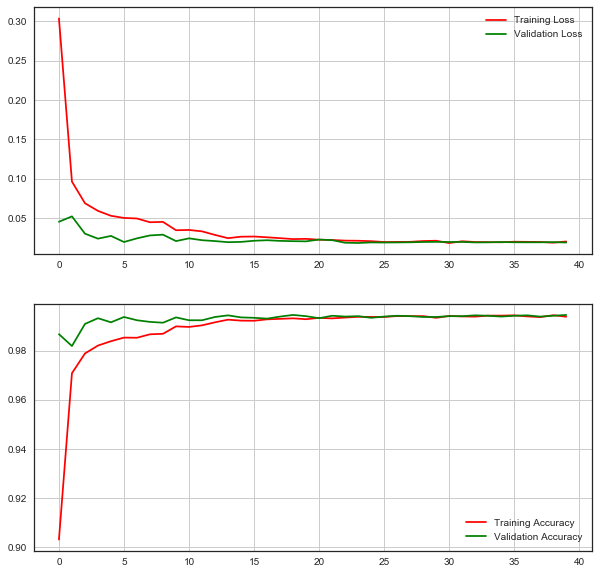

In [36]:
# learning curves
fig,ax = plt.subplots(2,1,figsize=(10,10))
ax[0].plot(history.history['loss'], color='r', label='Training Loss')
ax[0].plot(history.history['val_loss'], color='g', label='Validation Loss')
ax[0].legend(loc='best',shadow=True)
ax[0].grid(True)


ax[1].plot(history.history['acc'], color='r', label='Training Accuracy')
ax[1].plot(history.history['val_acc'], color='g', label='Validation Accuracy')
ax[1].legend(loc='best',shadow=True)
ax[1].grid(True)

In [42]:
# 混淆矩阵
def plot_sonfusion_matrix(cm, classes, normalize=False, title='Confusion matrix',cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
    thresh = cm.max()/2.0
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,i,cm[i,j], horizontalalignment='center',color='white' if cm[i,j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predict label')

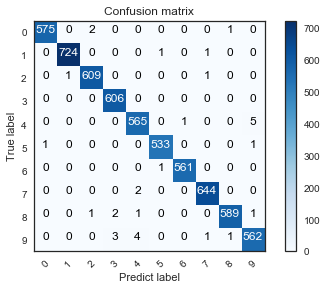

In [43]:
# 验证数据的混淆矩阵
pred_y = model.predict(val_x)
pred_label = np.argmax(pred_y, axis=1)
true_label = np.argmax(val_y, axis=1)

confusion_mat = confusion_matrix(true_label, pred_label)

plot_sonfusion_matrix(confusion_mat, classes = range(10))

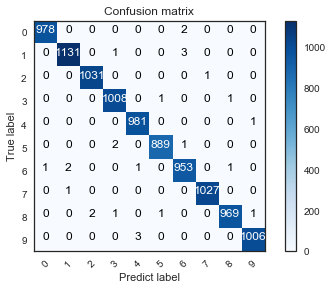

In [44]:
# 测试数据的混淆矩阵
pred_y = model.predict(test_x)
pred_label = np.argmax(pred_y, axis=1)
true_label = np.argmax(test_y, axis=1)

confusion_mat = confusion_matrix(true_label, pred_label)

plot_sonfusion_matrix(confusion_mat, classes = range(10))

In [55]:
# 测试集分类正确率
cnt = 0
for i in range(len(pred_label)):
    if pred_label[i] == true_label[i]:
        cnt += 1
print(cnt/len(true_label))

0.9973
